## 0.0 Import Packages

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import shap
from lightgbm import LGBMClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklift.datasets import fetch_criteo
from sklift.metrics import qini_auc_score, uplift_at_k, uplift_auc_score, uplift_by_percentile
from sklift.viz import (
    plot_qini_curve,
    plot_uplift_curve,
    plot_uplift_by_percentile,
)

pd.set_option("display.max_columns", 1200)

### 0.1 Utils

In [18]:
def get_metrics(y, uplift_effect, treatment):
    no_effect_share = round(
        100 * np.sum(uplift_effect == 0) / len(uplift_effect), 
        2
    )
    positive_effect_share = round(
        100 * np.sum(uplift_effect > 0) / len(uplift_effect), 
        2
    )
    negative_effect_share = round(
        100 * np.sum(uplift_effect < 0) / len(uplift_effect), 
        2
    )
    print(
        f"Model predicts positive effect in conversion after treatment for {positive_effect_share}% of cases."
    )
    print(
        f"Model predicts negative effect in conversion after treatment for {negative_effect_share}% of cases."
    )
    print(
        f"Model predicts no effect in conversion after treatment for {no_effect_share}% of cases."
    )
    
    uplift_at_10 = uplift_at_k(y, uplift_effect, treatment, strategy="overall", k=0.1)
    qini_coef = qini_auc_score(y, uplift_effect, treatment)
    uplift_auc = uplift_auc_score(y, uplift_effect, treatment)
    print(f"Uplift at 10% by overall: {uplift_at_10}")
    print(f"Qini coefficient - AUQC: {qini_coef}")
    print(f"Uplift AUC - AUUC: {uplift_auc}")
    

## 1.0 Data Exploration

In [2]:
dataset = fetch_criteo(target_col="conversion", treatment_col="treatment")
features, target, treatment = dataset.data, dataset.target, dataset.treatment

### 1.1 Features Description

In [5]:
features.describe()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11
count,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07
mean,1.962030e+01,1.006998e+01,8.446582e+00,4.178923e+00,1.033884e+01,4.028513e+00,-4.155356e+00,5.101765e+00,3.933581e+00,1.602764e+01,5.333396e+00,-1.709672e-01
std,5.377464e+00,1.047557e-01,2.993161e-01,1.336645e+00,3.433081e-01,4.310974e-01,4.577914e+00,1.205248e+00,5.665958e-02,7.018975e+00,1.682288e-01,2.283277e-02
min,1.261636e+01,1.005965e+01,8.214383e+00,-8.398387e+00,1.028053e+01,-9.011892e+00,-3.142978e+01,4.833815e+00,3.635107e+00,1.319006e+01,5.300375e+00,-1.383941e+00
25%,1.261636e+01,1.005965e+01,8.214383e+00,4.679882e+00,1.028053e+01,4.115453e+00,-6.699321e+00,4.833815e+00,3.910792e+00,1.319006e+01,5.300375e+00,-1.686792e-01
50%,2.192341e+01,1.005965e+01,8.214383e+00,4.679882e+00,1.028053e+01,4.115453e+00,-2.411115e+00,4.833815e+00,3.971858e+00,1.319006e+01,5.300375e+00,-1.686792e-01
75%,2.443646e+01,1.005965e+01,8.723335e+00,4.679882e+00,1.028053e+01,4.115453e+00,2.944427e-01,4.833815e+00,3.971858e+00,1.319006e+01,5.300375e+00,-1.686792e-01
max,2.674526e+01,1.634419e+01,9.051962e+00,4.679882e+00,2.112351e+01,4.115453e+00,2.944427e-01,1.199840e+01,3.971858e+00,7.529502e+01,6.473917e+00,-1.686792e-01


In [6]:
target.value_counts(normalize=True)

0    0.997083
1    0.002917
Name: conversion, dtype: Float64

In [9]:
treatment.value_counts(normalize=True)

1    0.85
0    0.15
Name: treatment, dtype: Float64

### 1.2 Train-Validation-Holdout Split

- Train: 80%
- Validation: 10%
- Holdout (Test): 10%

In [3]:
RANDOM_SEED = 42
VALIDATION_SIZE = 0.1
HOLDOUT_SIZE = 0.1

stratify_cols = pd.concat([treatment, target], axis=1)
X_train_val, X_holdout, y_train_val, y_holdout, trmnt_train_val, trmnt_holdout = train_test_split(
    features,
    target,
    treatment,
    test_size=HOLDOUT_SIZE,
    random_state=RANDOM_SEED,
    stratify=stratify_cols,
)

X_train, X_val, y_train, y_val, trmnt_train, trmnt_val = train_test_split(
    X_train_val,
    y_train_val,
    trmnt_train_val,
    test_size=VALIDATION_SIZE / (1 - HOLDOUT_SIZE),
    random_state=RANDOM_SEED,
    stratify=stratify_cols.loc[X_train_val.index],
)

In [4]:
print(y_train.value_counts(normalize=True))
print(y_val.value_counts(normalize=True))
print(y_holdout.value_counts(normalize=True))

0    0.997083
1    0.002917
Name: conversion, dtype: Float64
0    0.997084
1    0.002916
Name: conversion, dtype: Float64
0    0.997084
1    0.002916
Name: conversion, dtype: Float64


In [5]:
print(trmnt_train.value_counts(normalize=True))
print(trmnt_val.value_counts(normalize=True))
print(trmnt_holdout.value_counts(normalize=True))

1    0.85
0    0.15
Name: treatment, dtype: Float64
1    0.85
0    0.15
Name: treatment, dtype: Float64
1    0.85
0    0.15
Name: treatment, dtype: Float64


### 1.3 Add treatment flag as a feature

In [20]:
X_train["f12_trmnt"] = trmnt_train.astype(int)
X_val["f12_trmnt"] = trmnt_val.astype(int)

## 2.0 Modelling

In [7]:
IS_UNBALANCE = True
N_ESTIMATORS = 1000

y_train = y_train.astype(int)
y_val = y_val.astype(int)
y_holdout = y_holdout.astype(int)

### 2.1 Optuna Hyperparameter Tuning

In [8]:
def objective(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 5e-1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "min_child_samples": trial.suggest_int("min_child_samples", 3, 50),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-3, 1e2, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 1e2, log=True),
        "min_child_weight": trial.suggest_float("min_child_weight", 1e-3, 1e2, log=True),
        "early_stopping_rounds": trial.suggest_int("early_stopping_rounds", 10, 100),
        "n_estimators": N_ESTIMATORS,
        "objective": "binary",
        "random_state": RANDOM_SEED,
        "boosting_type": "gbdt",
        "importance_type": "gain",
        "is_unbalance": IS_UNBALANCE,
        "verbose": -1,
    }
    
    model = LGBMClassifier(
        **params
    )
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
    )
    
    calibrated_model_isotonic = CalibratedClassifierCV(model, method="isotonic", cv="prefit")
    calibrated_model_isotonic.fit(
        X_val, 
        y_val,
    )
    
    auc = roc_auc_score(
        y_val,
        calibrated_model_isotonic.predict_proba(X_val)[:, 1]
    )
    return auc

study_lgbm = optuna.create_study(
    direction="maximize", study_name="lgbm_s_learner"
)
study_lgbm.optimize(objective, n_trials=5) # increase n_trials to get better results
best_params = study_lgbm.best_params
print(f"Best params: {best_params}")
print(f"Best value: {study_lgbm.best_value}")    

[I 2025-03-02 14:14:32,292] A new study created in memory with name: lgbm_s_learner


[LightGBM] [Warning] early_stopping_round is set=79, early_stopping_rounds=79 will be ignored. Current value: early_stopping_round=79
[1]	valid_0's binary_logloss: 0.087122
[2]	valid_0's binary_logloss: 0.0900355
[3]	valid_0's binary_logloss: 0.0928595
[4]	valid_0's binary_logloss: 0.0953725
[5]	valid_0's binary_logloss: 0.0980239
[6]	valid_0's binary_logloss: 0.100534
[7]	valid_0's binary_logloss: 0.103008
[8]	valid_0's binary_logloss: 0.1054
[9]	valid_0's binary_logloss: 0.107798
[10]	valid_0's binary_logloss: 0.110127
[11]	valid_0's binary_logloss: 0.112432
[12]	valid_0's binary_logloss: 0.114766
[13]	valid_0's binary_logloss: 0.117019
[14]	valid_0's binary_logloss: 0.119226
[15]	valid_0's binary_logloss: 0.121376
[16]	valid_0's binary_logloss: 0.123485
[17]	valid_0's binary_logloss: 0.125629
[18]	valid_0's binary_logloss: 0.127686
[19]	valid_0's binary_logloss: 0.129712
[20]	valid_0's binary_logloss: 0.131676
[21]	valid_0's binary_logloss: 0.133588
[22]	valid_0's binary_logloss: 0.

[I 2025-03-02 14:15:29,628] Trial 0 finished with value: 0.9534433608495774 and parameters: {'learning_rate': 0.022318482356562436, 'num_leaves': 215, 'min_child_samples': 3, 'subsample': 0.5093639177774585, 'colsample_bytree': 0.6326410771462141, 'reg_alpha': 0.5290838565731685, 'reg_lambda': 2.8623186848700923, 'min_child_weight': 0.004189992149556215, 'early_stopping_rounds': 79}. Best is trial 0 with value: 0.9534433608495774.


[LightGBM] [Warning] early_stopping_round is set=54, early_stopping_rounds=54 will be ignored. Current value: early_stopping_round=54
[1]	valid_0's binary_logloss: 18.8803
[2]	valid_0's binary_logloss: 0.1687
[3]	valid_0's binary_logloss: 10.8942
[4]	valid_0's binary_logloss: 6.1361
[5]	valid_0's binary_logloss: 18.2161
[6]	valid_0's binary_logloss: 0.587892
[7]	valid_0's binary_logloss: 0.587892
[8]	valid_0's binary_logloss: 0.587892
[9]	valid_0's binary_logloss: 0.587892
[10]	valid_0's binary_logloss: 0.587892
[11]	valid_0's binary_logloss: 0.587892
[12]	valid_0's binary_logloss: 0.587892
[13]	valid_0's binary_logloss: 0.587892
[14]	valid_0's binary_logloss: 0.587892
[15]	valid_0's binary_logloss: 0.587892
[16]	valid_0's binary_logloss: 0.587892
[17]	valid_0's binary_logloss: 0.587892
[18]	valid_0's binary_logloss: 0.587892
[19]	valid_0's binary_logloss: 0.587892
[20]	valid_0's binary_logloss: 0.587892
[21]	valid_0's binary_logloss: 0.587892
[22]	valid_0's binary_logloss: 0.587892
[2

[I 2025-03-02 14:15:51,561] Trial 1 finished with value: 0.512444207259688 and parameters: {'learning_rate': 0.4412691103098801, 'num_leaves': 98, 'min_child_samples': 41, 'subsample': 0.8884910839942195, 'colsample_bytree': 0.5387112015624783, 'reg_alpha': 1.0374100711451775, 'reg_lambda': 0.009177270386871245, 'min_child_weight': 2.1169870772761774, 'early_stopping_rounds': 54}. Best is trial 0 with value: 0.9534433608495774.


[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[1]	valid_0's binary_logloss: 5.13318
[2]	valid_0's binary_logloss: 1.58582
[3]	valid_0's binary_logloss: 3.82119
[4]	valid_0's binary_logloss: 2.30109
[5]	valid_0's binary_logloss: 4.60218
[6]	valid_0's binary_logloss: 4.28581
[7]	valid_0's binary_logloss: 3.77574
[8]	valid_0's binary_logloss: 1.49969
[9]	valid_0's binary_logloss: 2.16444
[10]	valid_0's binary_logloss: 4.45145
[11]	valid_0's binary_logloss: 4.41257
[12]	valid_0's binary_logloss: 2.80539
[13]	valid_0's binary_logloss: 1.89903
[14]	valid_0's binary_logloss: 1.94696
[15]	valid_0's binary_logloss: 2.65199
[16]	valid_0's binary_logloss: 2.45789
[17]	valid_0's binary_logloss: 2.30362
[18]	valid_0's binary_logloss: 3.23805
[19]	valid_0's binary_logloss: 3.23551
[20]	valid_0's binary_logloss: 2.61196
[21]	valid_0's binary_logloss: 2.61287
[22]	valid_0's binary_logloss: 2.16492
[23]	valid_0's bi

[I 2025-03-02 14:16:14,802] Trial 2 finished with value: 0.8316439674461147 and parameters: {'learning_rate': 0.1443437751621256, 'num_leaves': 93, 'min_child_samples': 28, 'subsample': 0.5400764516184124, 'colsample_bytree': 0.5029812617920388, 'reg_alpha': 0.028734480809593916, 'reg_lambda': 31.749538386934542, 'min_child_weight': 0.06722893723751942, 'early_stopping_rounds': 30}. Best is trial 0 with value: 0.9534433608495774.


[LightGBM] [Warning] early_stopping_round is set=57, early_stopping_rounds=57 will be ignored. Current value: early_stopping_round=57
[1]	valid_0's binary_logloss: 6.8028
[2]	valid_0's binary_logloss: 0.403186
[3]	valid_0's binary_logloss: 6.75834
[4]	valid_0's binary_logloss: 6.63625
[5]	valid_0's binary_logloss: 4.56171
[6]	valid_0's binary_logloss: 4.75639
[7]	valid_0's binary_logloss: 4.33751
[8]	valid_0's binary_logloss: 4.80385
[9]	valid_0's binary_logloss: 4.34044
[10]	valid_0's binary_logloss: 4.46132
[11]	valid_0's binary_logloss: 4.47637
[12]	valid_0's binary_logloss: 4.39744
[13]	valid_0's binary_logloss: 4.29039
[14]	valid_0's binary_logloss: 4.279
[15]	valid_0's binary_logloss: 4.02271
[16]	valid_0's binary_logloss: 4.18997
[17]	valid_0's binary_logloss: 4.03635
[18]	valid_0's binary_logloss: 4.10765
[19]	valid_0's binary_logloss: 4.02505
[20]	valid_0's binary_logloss: 4.3079
[21]	valid_0's binary_logloss: 3.96743
[22]	valid_0's binary_logloss: 3.62035
[23]	valid_0's binar

[I 2025-03-02 14:17:01,717] Trial 3 finished with value: 0.5079328419384875 and parameters: {'learning_rate': 0.24382643764234999, 'num_leaves': 243, 'min_child_samples': 43, 'subsample': 0.9054816030415014, 'colsample_bytree': 0.8498279762735138, 'reg_alpha': 0.6946694485422535, 'reg_lambda': 29.58075087659789, 'min_child_weight': 0.12468853557881805, 'early_stopping_rounds': 57}. Best is trial 0 with value: 0.9534433608495774.


[LightGBM] [Warning] early_stopping_round is set=28, early_stopping_rounds=28 will be ignored. Current value: early_stopping_round=28
[1]	valid_0's binary_logloss: 0.0164384
[2]	valid_0's binary_logloss: 0.0167854
[3]	valid_0's binary_logloss: 0.0172645
[4]	valid_0's binary_logloss: 0.0178982
[5]	valid_0's binary_logloss: 0.0185064
[6]	valid_0's binary_logloss: 0.0191458
[7]	valid_0's binary_logloss: 0.0198126
[8]	valid_0's binary_logloss: 0.0205157
[9]	valid_0's binary_logloss: 0.0212182
[10]	valid_0's binary_logloss: 0.0219467
[11]	valid_0's binary_logloss: 0.0226695
[12]	valid_0's binary_logloss: 0.0234062
[13]	valid_0's binary_logloss: 0.0241541
[14]	valid_0's binary_logloss: 0.0249017
[15]	valid_0's binary_logloss: 0.025655
[16]	valid_0's binary_logloss: 0.0264112
[17]	valid_0's binary_logloss: 0.0271723
[18]	valid_0's binary_logloss: 0.0279389
[19]	valid_0's binary_logloss: 0.0287101
[20]	valid_0's binary_logloss: 0.0294821
[21]	valid_0's binary_logloss: 0.0302539
[22]	valid_0's 

[I 2025-03-02 14:17:33,647] Trial 4 finished with value: 0.9577968348372715 and parameters: {'learning_rate': 0.0065905503578600816, 'num_leaves': 167, 'min_child_samples': 31, 'subsample': 0.5736468164840244, 'colsample_bytree': 0.7911396664232997, 'reg_alpha': 0.0060725784039746804, 'reg_lambda': 0.182697414120272, 'min_child_weight': 18.162668102386867, 'early_stopping_rounds': 28}. Best is trial 4 with value: 0.9577968348372715.


Best params: {'learning_rate': 0.0065905503578600816, 'num_leaves': 167, 'min_child_samples': 31, 'subsample': 0.5736468164840244, 'colsample_bytree': 0.7911396664232997, 'reg_alpha': 0.0060725784039746804, 'reg_lambda': 0.182697414120272, 'min_child_weight': 18.162668102386867, 'early_stopping_rounds': 28}
Best value: 0.9577968348372715


In [9]:
optuna.visualization.plot_optimization_history(study_lgbm)

### 2.2 Model Training

In [12]:
model = LGBMClassifier(
    **best_params,
    importance_type="gain",
    n_estimators=N_ESTIMATORS,
    random_state=RANDOM_SEED,
    boosting_type="gbdt",
    objective="binary",
    is_unbalance=IS_UNBALANCE,
    verbose=-1,
)
model.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],
)
calibrated_model = CalibratedClassifierCV(model, method="isotonic", cv="prefit")
calibrated_model.fit(
    X_val, 
    y_val,
)

[LightGBM] [Warning] early_stopping_round is set=28, early_stopping_rounds=28 will be ignored. Current value: early_stopping_round=28
[1]	valid_0's binary_logloss: 0.0164384
[2]	valid_0's binary_logloss: 0.0167854
[3]	valid_0's binary_logloss: 0.0172645
[4]	valid_0's binary_logloss: 0.0178982
[5]	valid_0's binary_logloss: 0.0185064
[6]	valid_0's binary_logloss: 0.0191458
[7]	valid_0's binary_logloss: 0.0198126
[8]	valid_0's binary_logloss: 0.0205157
[9]	valid_0's binary_logloss: 0.0212182
[10]	valid_0's binary_logloss: 0.0219467
[11]	valid_0's binary_logloss: 0.0226695
[12]	valid_0's binary_logloss: 0.0234062
[13]	valid_0's binary_logloss: 0.0241541
[14]	valid_0's binary_logloss: 0.0249017
[15]	valid_0's binary_logloss: 0.025655
[16]	valid_0's binary_logloss: 0.0264112
[17]	valid_0's binary_logloss: 0.0271723
[18]	valid_0's binary_logloss: 0.0279389
[19]	valid_0's binary_logloss: 0.0287101
[20]	valid_0's binary_logloss: 0.0294821
[21]	valid_0's binary_logloss: 0.0302539
[22]	valid_0's 

CalibratedClassifierCV(base_estimator=LGBMClassifier(colsample_bytree=0.7911396664232997,
                                                     early_stopping_rounds=28,
                                                     importance_type='gain',
                                                     is_unbalance=True,
                                                     learning_rate=0.0065905503578600816,
                                                     min_child_samples=31,
                                                     min_child_weight=18.162668102386867,
                                                     n_estimators=1000,
                                                     num_leaves=167,
                                                     objective='binary',
                                                     random_state=42,
                                                     reg_alpha=0.0060725784039746804,
                                                     reg_lambda=0.182697414120272,
                                                     subsample=0.5736468164840244,
                                                     verbose=-1),
                       cv='prefit', method='isotonic')

## 3.0 Evaluation

### 3.1 Validation Set

In [19]:
uplift_effect_val = calibrated_model.predict_proba(X_val)[:, 1]
get_metrics(y_val, uplift_effect_val, trmnt_val)

Model predicts positive effect in conversion after treatment for 99.93% of cases.
Model predicts negative effect in conversion after treatment for 0.0% of cases.
Model predicts no effect in conversion after treatment for 0.07% of cases.
Uplift at 10% by overall: 0.0036818791827395933
Qini coefficient - AUQC: 0.14937917665861927
Uplift AUC - AUUC: 0.004779173118348771


### 3.2 Holdout Set

In [21]:
X_holdout_if_treatment = X_holdout.copy()
X_holdout_if_treatment["f12_trmnt"] = 1
X_holdout_if_control = X_holdout.copy()
X_holdout_if_control["f12_trmnt"] = 0

uplift_effect_pred = calibrated_model.predict_proba(X_holdout_if_treatment)[:, 1] - calibrated_model.predict_proba(X_holdout_if_control)[:, 1]
get_metrics(y_holdout, uplift_effect_pred, trmnt_holdout)

Model predicts positive effect in conversion after treatment for 13.01% of cases.
Model predicts negative effect in conversion after treatment for 0.77% of cases.
Model predicts no effect in conversion after treatment for 86.21% of cases.
Uplift at 10% by overall: 0.004635011851808771
Qini coefficient - AUQC: 0.07642832010047636
Uplift AUC - AUUC: 0.0024647392210433838


In [26]:
uplift_by_percentile_pddf = uplift_by_percentile(
    y_holdout, uplift_effect_pred, trmnt_holdout, strategy="overall", bins=10
)
uplift_by_percentile_pddf.reset_index().head(10)

,percentile,n_treatment,n_control,response_rate_treatment,response_rate_control,uplift
0,0-10,120007,19789,0.006808,0.002173,0.004635
1,10-20,118697,21099,0.002140,0.001280,0.000860
2,20-30,118627,21169,0.002773,0.001512,0.001262
3,30-40,118626,21170,0.002613,0.002220,0.000393
4,40-50,118594,21202,0.002656,0.002075,0.000581
5,50-60,118791,21005,0.002719,0.002000,0.000720
6,60-70,118822,20974,0.002760,0.002146,0.000615
7,70-80,118603,21193,0.002749,0.001699,0.001050
8,80-90,118895,20901,0.002994,0.002249,0.000746
9,90-100,118604,21192,0.002639,0.002029,0.000610


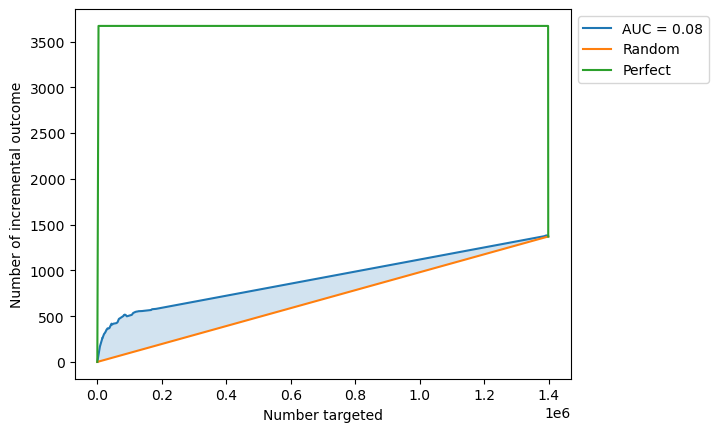

In [28]:
plot_qini_curve(y_holdout, uplift_effect_pred, trmnt_holdout, perfect=True)

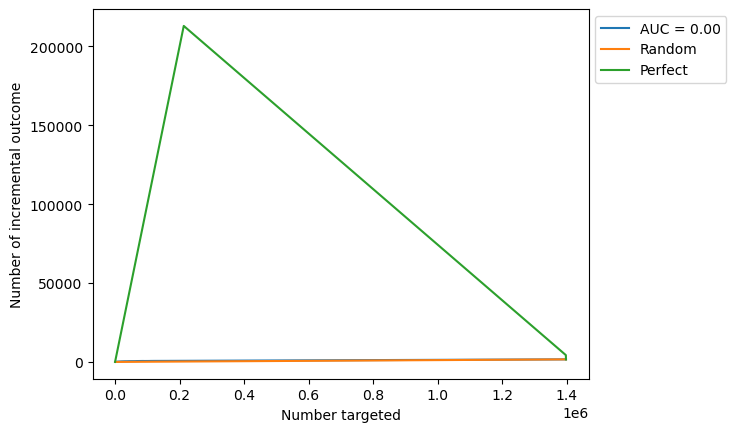

In [29]:
plot_uplift_curve(y_holdout, uplift_effect_pred, trmnt_holdout, perfect=True)

/Users/luna/anaconda3/envs/yh_py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3156: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



<AxesSubplot: title={'center': 'Uplift by percentile\nweighted average uplift = 0.0012'}, xlabel='Percentile', ylabel='Uplift = treatment response rate - control response rate'>

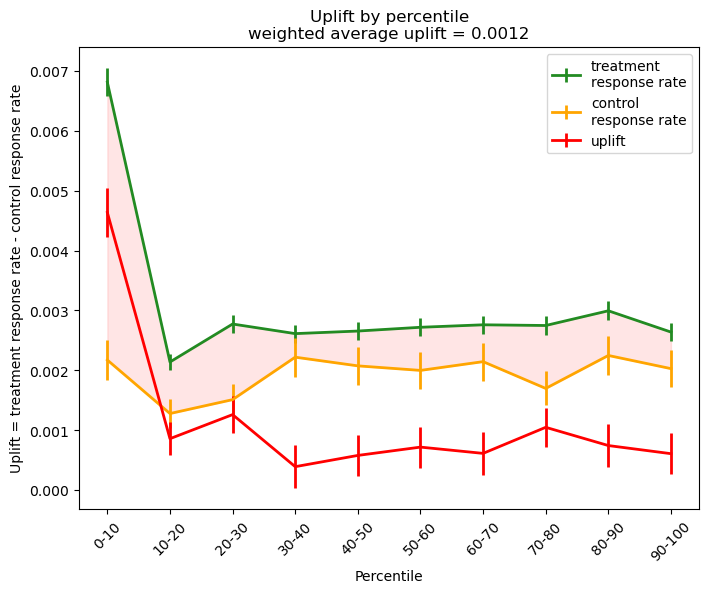

In [32]:
plot_uplift_by_percentile(y_holdout, uplift_effect_pred, trmnt_holdout, strategy="overall", bins=10)

In [33]:
score_if_treatment = calibrated_model.predict_proba(X_holdout_if_treatment)[:, 1]
score_if_control = calibrated_model.predict_proba(X_holdout_if_control)[:, 1]
uplift_effect_pred = score_if_treatment - score_if_control

final_result = pd.DataFrame(
    {
        "score_if_treatment": score_if_treatment,
        "score_if_control": score_if_control,
        "uplift_effect_pred": uplift_effect_pred,
        "treatment": trmnt_holdout,
        "conversion": y_holdout,
    }
)
final_result["group"] = final_result["treatment"].apply(
    lambda x: "treatment" if x == 1 else "control"
)
final_result["uplift_score_pctl"] = 100 - pd.qcut(
    final_result["uplift_effect_pred"].rank(method="first"), 100, labels=False
)

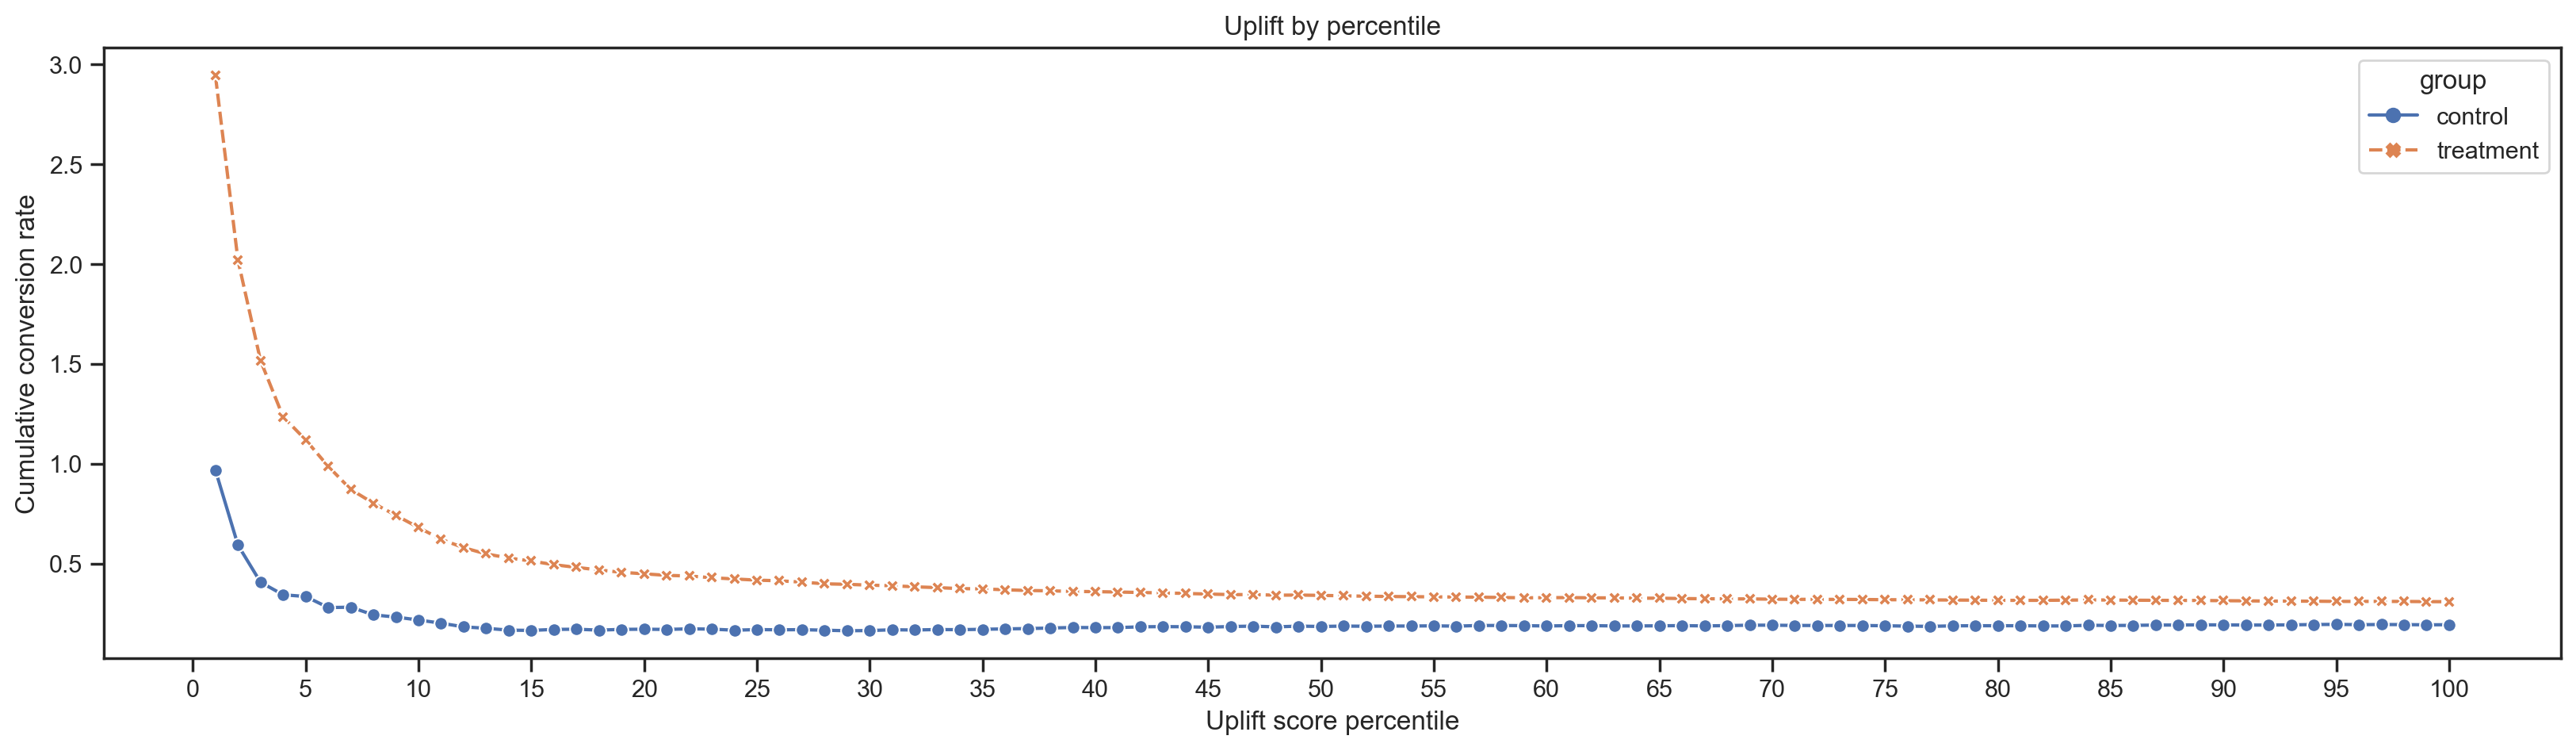

In [37]:
pctl = (
    final_result.groupby(["uplift_score_pctl", "group"]).agg(
        base_size=("score_if_control", "count"),
        conversion_rate=("conversion", lambda x: x.mean() * 100),
        takeup_count=("conversion", "sum")
    )
    .reset_index()
)
pctl["cumulative_takeup_count"] = pctl.groupby("group")["takeup_count"].cumsum()
pctl["cumulative_base_size"] = pctl.groupby("group")["base_size"].cumsum()
pctl["cumulative_conversion_rate"] = (
    pctl["cumulative_takeup_count"] / pctl["cumulative_base_size"] * 100
)

sns.set(style="ticks", font_scale=1)
plt.figure(figsize=(20, 5), dpi=200)
sns.lineplot(
    x=pctl["uplift_score_pctl"],
    y=pctl["cumulative_conversion_rate"],
    hue=pctl["group"],
    style=pctl["group"],
    markers=True,
)
plt.title("Uplift by percentile")
plt.xlabel("Uplift score percentile")
plt.ylabel("Cumulative conversion rate")
plt.xticks(np.arange(0, 105, 5))
plt.show()

## 4.0 Explainability

### 4.1 Feature Importance

In [40]:
importances = model.feature_importances_
features = model.feature_name_

importances_pddf = pd.DataFrame({"feature": features, "importance": importances})
importances_pddf = importances_pddf.sort_values("importance", ascending=False)
importances_pddf.head(10)

,feature,importance
4,f4,9.695016e+08
2,f2,2.822970e+08
6,f6,3.575240e+07
3,f3,3.005251e+07
12,f12_trmnt,2.090286e+06
7,f7,1.487931e+06
10,f10,6.307350e+05
11,f11,8.991640e+04
0,f0,0.000000e+00
1,f1,0.000000e+00


### 4.2 SHAP Values

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


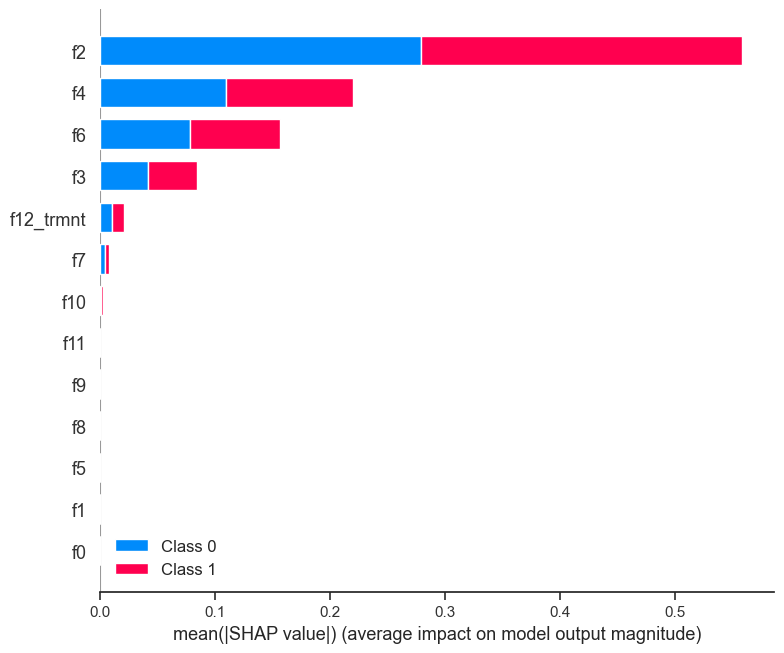

In [48]:
explainer = shap.TreeExplainer(model, feature_perturbation="tree_path_dependent")
shap_values = explainer.shap_values(X_train, y_train)

shap.summary_plot(shap_values, X_train)